## Please see the last part for homework answers!

In [52]:
import argparse
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [13]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [14]:
batch_size = 32
#batch_size = 5 # for testing
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [15]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [16]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Looking are images

In [17]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [18]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(32, 1, 28, 28)

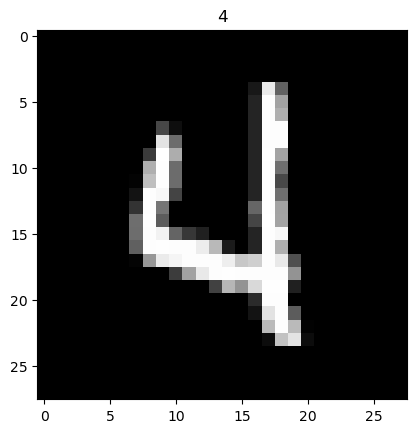

In [19]:
show(X[0][0], Y[0])

In [20]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [21]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [22]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    for epoch in range(num_epochs):
        sum_loss = 0.0
        total = 0
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28) #.cuda()
            # Fill in here please

            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            total += batch
            sum_loss += batch * loss.item()

        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [23]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)  #.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [26]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Models with Dropout

In [27]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

# Homework Answer:

## 3.1

In [33]:
lrs = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
accs = []
for i in lrs:
    net = get_model()
    learning_rate = i
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    accs.append(val_acc)
accs

Epoch [1/10], Loss: 75.9953
Epoch [1/10], Valid Accuracy: 10.1400, Valid Loss: 2.3983
Epoch [2/10], Loss: 3.3413
Epoch [2/10], Valid Accuracy: 8.9700, Valid Loss: 2.4071
Epoch [3/10], Loss: 2.5148
Epoch [3/10], Valid Accuracy: 9.7900, Valid Loss: 2.4783
Epoch [4/10], Loss: 2.4095
Epoch [4/10], Valid Accuracy: 10.3300, Valid Loss: 2.3555
Epoch [5/10], Loss: 2.4041
Epoch [5/10], Valid Accuracy: 11.4000, Valid Loss: 2.3676
Epoch [6/10], Loss: 2.4057
Epoch [6/10], Valid Accuracy: 10.1500, Valid Loss: 2.4834
Epoch [7/10], Loss: 2.4144
Epoch [7/10], Valid Accuracy: 9.8700, Valid Loss: 2.5034
Epoch [8/10], Loss: 2.4064
Epoch [8/10], Valid Accuracy: 9.7900, Valid Loss: 2.3734
Epoch [9/10], Loss: 2.4063
Epoch [9/10], Valid Accuracy: 11.4000, Valid Loss: 2.4149
Epoch [10/10], Loss: 2.4094
Epoch [10/10], Valid Accuracy: 8.9700, Valid Loss: 2.4437
Epoch [1/10], Loss: 2.7754
Epoch [1/10], Valid Accuracy: 14.3800, Valid Loss: 2.2607
Epoch [2/10], Loss: 2.3291
Epoch [2/10], Valid Accuracy: 10.1000, V

[8.97, 10.29, 93.5, 97.67, 98.02, 93.86]

In [53]:
df1 = pd.DataFrame({'Learning rate': lrs, 'Val Accuracy': accs})
df1

,Learning rate,Val Accuracy
0,1.00000,8.97
1,0.10000,10.29
2,0.01000,93.50
3,0.00100,97.67
4,0.00010,98.02
5,0.00001,93.86


### Comment:

#### The best two learning rates are 0.001 and 0.0001, with validation accuracy of 97.67 and 98.02

## 3.2

In [35]:
layer_sizes = [10, 50, 100, 300, 1000, 2000]
accs_layer = []
for i in layer_sizes:
    net = get_model_v2(M = i, p=0)
    learning_rate = 0.01
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    accs_layer.append(val_acc)
accs_layer

Epoch [1/10], Loss: 0.4231
Epoch [1/10], Valid Accuracy: 88.9600, Valid Loss: 0.3908
Epoch [2/10], Loss: 0.3641
Epoch [2/10], Valid Accuracy: 89.4500, Valid Loss: 0.3636
Epoch [3/10], Loss: 0.3553
Epoch [3/10], Valid Accuracy: 89.7800, Valid Loss: 0.3752
Epoch [4/10], Loss: 0.3550
Epoch [4/10], Valid Accuracy: 90.4400, Valid Loss: 0.3646
Epoch [5/10], Loss: 0.3516
Epoch [5/10], Valid Accuracy: 90.1500, Valid Loss: 0.3747
Epoch [6/10], Loss: 0.3495
Epoch [6/10], Valid Accuracy: 89.6500, Valid Loss: 0.3967
Epoch [7/10], Loss: 0.3447
Epoch [7/10], Valid Accuracy: 90.1200, Valid Loss: 0.3521
Epoch [8/10], Loss: 0.3450
Epoch [8/10], Valid Accuracy: 90.9400, Valid Loss: 0.3461
Epoch [9/10], Loss: 0.3433
Epoch [9/10], Valid Accuracy: 90.2700, Valid Loss: 0.3518
Epoch [10/10], Loss: 0.3454
Epoch [10/10], Valid Accuracy: 89.9400, Valid Loss: 0.3830
Epoch [1/10], Loss: 0.3375
Epoch [1/10], Valid Accuracy: 91.3300, Valid Loss: 0.2874
Epoch [2/10], Loss: 0.2620
Epoch [2/10], Valid Accuracy: 93.130

[89.94, 92.34, 94.02, 94.3, 94.33, 94.4]

In [55]:
df2 = pd.DataFrame({'Layer Size': layer_sizes, 'Val Accuracy': accs_layer})
df2

,Layer Size,Val Accuracy
0,10,89.94
1,50,92.34
2,100,94.02
3,300,94.30
4,1000,94.33
5,2000,94.40


### Comment:

#### The best layer size is 1000, with the validation accuracy being 94.33. The layer sizes of 100, 300, 1000, and 2000 might overfit, since the marginal increase of validation accuracy is very small. 

## 3.3

In [43]:
wds = [0, 0.0001, 0.001, 0.01, 0.1, 0.3]
accs_wds = []
train_losses = []
val_losses = []
for i in wds:
    net = get_model_v2(M = 300, p=0)
    learning_rate = 0.001
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = i)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    accs_wds.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
accs_wds

Epoch [1/20], Loss: 0.1999
Epoch [1/20], Valid Accuracy: 97.1700, Valid Loss: 0.0945
Epoch [2/20], Loss: 0.0872
Epoch [2/20], Valid Accuracy: 97.4400, Valid Loss: 0.0855
Epoch [3/20], Loss: 0.0630
Epoch [3/20], Valid Accuracy: 97.1100, Valid Loss: 0.0941
Epoch [4/20], Loss: 0.0477
Epoch [4/20], Valid Accuracy: 97.4700, Valid Loss: 0.0903
Epoch [5/20], Loss: 0.0382
Epoch [5/20], Valid Accuracy: 97.4300, Valid Loss: 0.0881
Epoch [6/20], Loss: 0.0299
Epoch [6/20], Valid Accuracy: 97.1300, Valid Loss: 0.1091
Epoch [7/20], Loss: 0.0276
Epoch [7/20], Valid Accuracy: 97.2700, Valid Loss: 0.1123
Epoch [8/20], Loss: 0.0230
Epoch [8/20], Valid Accuracy: 97.5600, Valid Loss: 0.1202
Epoch [9/20], Loss: 0.0218
Epoch [9/20], Valid Accuracy: 97.8700, Valid Loss: 0.1005
Epoch [10/20], Loss: 0.0189
Epoch [10/20], Valid Accuracy: 97.7900, Valid Loss: 0.1054
Epoch [11/20], Loss: 0.0193
Epoch [11/20], Valid Accuracy: 98.0900, Valid Loss: 0.1005
Epoch [12/20], Loss: 0.0194
Epoch [12/20], Valid Accuracy: 98

[97.75, 97.56, 97.44, 95.45, 89.49, 83.77]

In [56]:
df3 = pd.DataFrame({'Weight Decay': wds, 'Val Accuracy': accs_wds, 'train loss': train_losses, 'validation loss': val_losses})
df3

,Weight Decay,Val Accuracy,train loss,validation loss
0,0.0000,97.75,0.012886,0.157058
1,0.0001,97.56,0.023799,0.098141
2,0.0010,97.44,0.063027,0.079019
3,0.0100,95.45,0.166016,0.164493
4,0.1000,89.49,0.466684,0.448452
5,0.3000,83.77,0.818007,0.797153


## 3.4

In [48]:
dos = [0, 0.2, 0.4, 0.6, 0.8, 1]
accs_dos = []
train_losses_dos = []
val_losses_dos = []
for i in dos:
    net = get_model_v2(M = 300, p=i)
    if i <= 10: 
        learning_rate = 0.001
    else:
        learning_rate = 0.0002
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    accs_dos.append(val_acc)
    train_losses_dos.append(train_loss)
    val_losses_dos.append(val_loss)

Epoch [1/20], Loss: 0.2010
Epoch [1/20], Valid Accuracy: 97.0400, Valid Loss: 0.0994
Epoch [2/20], Loss: 0.0898
Epoch [2/20], Valid Accuracy: 97.0000, Valid Loss: 0.1020
Epoch [3/20], Loss: 0.0618
Epoch [3/20], Valid Accuracy: 97.2100, Valid Loss: 0.0862
Epoch [4/20], Loss: 0.0482
Epoch [4/20], Valid Accuracy: 97.7100, Valid Loss: 0.0789
Epoch [5/20], Loss: 0.0395
Epoch [5/20], Valid Accuracy: 97.6400, Valid Loss: 0.0899
Epoch [6/20], Loss: 0.0326
Epoch [6/20], Valid Accuracy: 97.9600, Valid Loss: 0.0874
Epoch [7/20], Loss: 0.0282
Epoch [7/20], Valid Accuracy: 97.4700, Valid Loss: 0.1054
Epoch [8/20], Loss: 0.0230
Epoch [8/20], Valid Accuracy: 97.5700, Valid Loss: 0.1026
Epoch [9/20], Loss: 0.0248
Epoch [9/20], Valid Accuracy: 97.7700, Valid Loss: 0.1083
Epoch [10/20], Loss: 0.0191
Epoch [10/20], Valid Accuracy: 97.7200, Valid Loss: 0.1070
Epoch [11/20], Loss: 0.0200
Epoch [11/20], Valid Accuracy: 97.8400, Valid Loss: 0.1119
Epoch [12/20], Loss: 0.0169
Epoch [12/20], Valid Accuracy: 97

In [57]:
df4 = pd.DataFrame({'Dropout': dos, 'Val Accuracy': accs_dos, 'train loss': train_losses_dos, 'validation loss': val_losses_dos})
df4

,Dropout,Val Accuracy,train loss,validation loss
0,0.0,97.76,0.012641,0.159660
1,0.2,97.69,0.016129,0.166253
2,0.4,98.16,0.015384,0.149909
3,0.6,97.79,0.009809,0.153156
4,0.8,97.92,0.014509,0.150092
5,1.0,97.84,0.013618,0.146572


### Comment:

#### In terms of validation accuracy, dropout = 0.4 achieved the best performance. The dropout does help to increase testing accuracy compared to the model without dropout, and this accuracy is better than that of L2 regularization. It is because dropout helps prevent overfitting, thus increases the predictive accuracy.